# 🎮 Assignment 1: Policy Iteration in the Repeated Prisoner's Dilemma

**Course**: Reinforcement Learning 2026A  
**Students**: Dor (ID: XXXXXXXXX), Sara (ID: XXXXXXXXX)

---

## 📋 Table of Contents

1. [Part I: Build the Environment](#part1)
2. [Part II: Define the MDP](#part2)
3. [Part III: Policy Iteration Algorithm](#part3)
4. [Part IV: Experiments & Analysis](#part4)
5. [Answers to Key Questions](#answers)
6. [Visualizations & Animations](#viz)

---

## What This Notebook Does (Simple Explanation)

Imagine playing a game repeatedly with a friend. Each round, you both choose to either **help each other** (Cooperate) or **betray** (Defect). The points you get depend on both choices:

- Both cooperate → 3 points each (win-win!)
- You betray, they help → 5 points for you, 0 for them
- Both betray → 1 point each (lose-lose)

**Our Goal**: Use math (Policy Iteration) to find the BEST strategy against different types of opponents.

In [1]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                    SETUP & IMPORTS                           ║
# ╚══════════════════════════════════════════════════════════════╝

# Install required packages
!pip install gymnasium==1.1.1 matplotlib pandas moviepy==1.0.3 pillow -q

import gymnasium as gym
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from IPython.display import display, HTML, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✅ Setup complete!")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\dorfe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


✅ Setup complete!


<a id='part1'></a>
---
# Part I: Build the Environment
---

## What We're Building

A **Gymnasium environment** is a standard format for RL problems. It has:
- `reset()`: Start a new game
- `step(action)`: Play one round, get reward and new state

We need to support:
- **4 opponent types**: ALL_C, ALL_D, TFT, IMPERFECT_TFT
- **2 memory lengths**: Memory-1 (see last round), Memory-2 (see last 2 rounds)

In [2]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                    CONSTANTS                                  ║
# ╚══════════════════════════════════════════════════════════════╝

# Actions: 0 = Cooperate, 1 = Defect
COOPERATE = 0
DEFECT = 1
ACTIONS = [COOPERATE, DEFECT]

# For printing
ACTION_NAMES = {COOPERATE: 'C', DEFECT: 'D'}

# Payoff Matrix: (my_action, opponent_action) -> my_reward
# T > R > P > S creates the dilemma
PAYOFF_MATRIX = {
    (COOPERATE, COOPERATE): 3,  # R (Reward) - mutual cooperation
    (COOPERATE, DEFECT):    0,  # S (Sucker) - I'm nice, they betray
    (DEFECT, COOPERATE):    5,  # T (Temptation) - I betray, they're nice
    (DEFECT, DEFECT):       1,  # P (Punishment) - mutual betrayal
}

print("Payoff Matrix:")
print("              | Opp: C | Opp: D")
print(f"Agent: C      |   3    |   0   ")
print(f"Agent: D      |   5    |   1   ")
print("\nNote: T(5) > R(3) > P(1) > S(0) - This creates the dilemma!")

Payoff Matrix:
              | Opp: C | Opp: D
Agent: C      |   3    |   0   
Agent: D      |   5    |   1   

Note: T(5) > R(3) > P(1) > S(0) - This creates the dilemma!


In [3]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 OPPONENT STRATEGIES                           ║
# ╚══════════════════════════════════════════════════════════════╝

def get_opponent_action(strategy: str, history: list) -> int:
    """
    Determine opponent's action based on their strategy.

    Parameters
    ----------
    strategy : str
        One of: "ALL_C", "ALL_D", "TFT", "IMPERFECT_TFT"
    history : list
        List of (agent_action, opponent_action) tuples from past rounds

    Returns
    -------
    int
        COOPERATE (0) or DEFECT (1)
    """
    # ALL_C: Always cooperate (the naive nice guy)
    if strategy == "ALL_C":
        return COOPERATE

    # ALL_D: Always defect (the villain)
    if strategy == "ALL_D":
        return DEFECT

    # TFT: Start nice, then copy opponent's last move
    if strategy == "TFT":
        if len(history) == 0:
            return COOPERATE  # Start cooperating
        return history[-1][0]  # Copy agent's last action

    # IMPERFECT_TFT: Like TFT but 10% chance of error
    if strategy == "IMPERFECT_TFT":
        if len(history) == 0:
            return COOPERATE
        intended = history[-1][0]  # What TFT would do
        if random.random() < 0.10:  # 10% slip
            return 1 - intended  # Do opposite
        return intended

    raise ValueError(f"Unknown strategy: {strategy}")

In [4]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 GYMNASIUM ENVIRONMENT                         ║
# ╚══════════════════════════════════════════════════════════════╝

class PrisonerDilemmaEnv(gym.Env):
    """
    Repeated Prisoner's Dilemma Environment.

    This environment supports different opponent strategies and
    memory lengths (observation schemes).

    Attributes
    ----------
    opponent_strategy : str
        The opponent's strategy (ALL_C, ALL_D, TFT, IMPERFECT_TFT)
    memory_length : int
        How many past rounds the agent observes (1 or 2)
    """

    def __init__(self, opponent_strategy: str, memory_length: int = 1):
        """Initialize the environment."""
        super().__init__()

        assert opponent_strategy in ["ALL_C", "ALL_D", "TFT", "IMPERFECT_TFT"]
        assert memory_length in [1, 2]

        self.opponent_strategy = opponent_strategy
        self.memory_length = memory_length

        # Action space: Cooperate (0) or Defect (1)
        self.action_space = gym.spaces.Discrete(2)

        # State space size depends on memory
        # Memory-1: 2^2 = 4 states
        # Memory-2: 2^4 = 16 states
        n_states = 4 if memory_length == 1 else 16
        self.observation_space = gym.spaces.Discrete(n_states)

        self.history = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to initial state.

        Per assignment: assume both agents cooperated before game started.
        """
        super().reset(seed=seed)

        # Initialize history with mutual cooperation
        self.history = [(COOPERATE, COOPERATE)] * self.memory_length

        return self._get_state(), {}

    def step(self, action: int):
        """
        Execute one round of the game.

        Parameters
        ----------
        action : int
            Agent's action (0=Cooperate, 1=Defect)

        Returns
        -------
        tuple
            (state, reward, terminated, truncated, info)
        """
        # Get opponent's action
        opp_action = get_opponent_action(self.opponent_strategy, self.history)

        # Calculate reward
        reward = PAYOFF_MATRIX[(action, opp_action)]

        # Update history
        self.history.append((action, opp_action))
        if len(self.history) > self.memory_length:
            self.history.pop(0)

        # Game never terminates (infinite horizon)
        return self._get_state(), reward, False, False, {'opp_action': opp_action}

    def _get_state(self):
        """
        Get current state based on memory length.

        Memory-1: (agent_t-1, opponent_t-1)
        Memory-2: (agent_t-1, agent_t-2, opponent_t-1, opponent_t-2)
        """
        if self.memory_length == 1:
            return self.history[-1]  # (a_{t-1}, b_{t-1})
        else:
            # (a_{t-1}, a_{t-2}, b_{t-1}, b_{t-2})
            return (
                self.history[-1][0],  # a_{t-1}
                self.history[-2][0],  # a_{t-2}
                self.history[-1][1],  # b_{t-1}
                self.history[-2][1],  # b_{t-2}
            )

print("✅ Environment class created!")

✅ Environment class created!


In [5]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 ENVIRONMENT TEST                              ║
# ╚══════════════════════════════════════════════════════════════╝

print("🧪 Testing Environment (Memory-1 vs TFT)")
print("="*55)

env = PrisonerDilemmaEnv("TFT", memory_length=1)
state, _ = env.reset()

test_moves = [COOPERATE, DEFECT, DEFECT, COOPERATE, COOPERATE]
expected = [(COOPERATE, 3), (COOPERATE, 5), (DEFECT, 1), (DEFECT, 0), (COOPERATE, 3)]

print(f"Initial state: {state} = ({ACTION_NAMES[state[0]]},{ACTION_NAMES[state[1]]})")
print("\nRound | Agent | TFT Response | Reward | Check")
print("-"*55)

all_pass = True
for i, (action, (exp_opp, exp_rew)) in enumerate(zip(test_moves, expected)):
    state, reward, _, _, info = env.step(action)
    opp = info['opp_action']
    check = "✅" if opp == exp_opp and reward == exp_rew else "❌"
    all_pass = all_pass and (opp == exp_opp and reward == exp_rew)
    print(f"  {i+1}   |   {ACTION_NAMES[action]}   |      {ACTION_NAMES[opp]}       |   {reward}    | {check}")

print("\n" + ("🎉 All tests passed!" if all_pass else "❌ Some tests failed!"))

🧪 Testing Environment (Memory-1 vs TFT)
Initial state: (0, 0) = (C,C)

Round | Agent | TFT Response | Reward | Check
-------------------------------------------------------
  1   |   C   |      C       |   3    | ✅
  2   |   D   |      C       |   5    | ✅
  3   |   D   |      D       |   1    | ✅
  4   |   C   |      D       |   0    | ✅
  5   |   C   |      C       |   3    | ✅

🎉 All tests passed!


<a id='part2'></a>
---
# Part II: Define the MDP
---

## What is an MDP?

A **Markov Decision Process** is defined by:
- **S**: Set of states (what situations can we be in?)
- **A**: Set of actions (what can we do?)
- **P(s'|s,a)**: Transition probabilities (where do we go next?)
- **R(s,a)**: Rewards (how many points?)
- **γ**: Discount factor (how much do we care about the future?)

In [6]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 STATE SPACE DEFINITION                        ║
# ╚══════════════════════════════════════════════════════════════╝

def get_all_states(memory_length: int) -> list:
    """
    Generate all possible states for a given memory length.

    Memory-1: 4 states (a_{t-1}, b_{t-1})
    Memory-2: 16 states (a_{t-1}, a_{t-2}, b_{t-1}, b_{t-2})
    """
    if memory_length == 1:
        return list(product([COOPERATE, DEFECT], repeat=2))
    else:
        return list(product([COOPERATE, DEFECT], repeat=4))

def state_to_str(state: tuple) -> str:
    """Convert state tuple to readable string like (C,D)."""
    return '(' + ','.join(ACTION_NAMES[a] for a in state) + ')'

# Display state spaces
print("📊 STATE SPACES")
print("="*60)

print("\n【Memory-1 State Space】")
print("Format: (a_{t-1}, b_{t-1}) where a=agent, b=opponent")
print(f"Total states: |S| = 4")
print("States:", [state_to_str(s) for s in get_all_states(1)])

print("\n【Memory-2 State Space】")
print("Format: (a_{t-1}, a_{t-2}, b_{t-1}, b_{t-2})")
print(f"Total states: |S| = 16")
m2_states = get_all_states(2)
print("States (first 8):", [state_to_str(s) for s in m2_states[:8]])
print("        (last 8):", [state_to_str(s) for s in m2_states[8:]])

📊 STATE SPACES

【Memory-1 State Space】
Format: (a_{t-1}, b_{t-1}) where a=agent, b=opponent
Total states: |S| = 4
States: ['(C,C)', '(C,D)', '(D,C)', '(D,D)']

【Memory-2 State Space】
Format: (a_{t-1}, a_{t-2}, b_{t-1}, b_{t-2})
Total states: |S| = 16
States (first 8): ['(C,C,C,C)', '(C,C,C,D)', '(C,C,D,C)', '(C,C,D,D)', '(C,D,C,C)', '(C,D,C,D)', '(C,D,D,C)', '(C,D,D,D)']
        (last 8): ['(D,C,C,C)', '(D,C,C,D)', '(D,C,D,C)', '(D,C,D,D)', '(D,D,C,C)', '(D,D,C,D)', '(D,D,D,C)', '(D,D,D,D)']


In [7]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 BUILD MDP MATRICES                            ║
# ╚══════════════════════════════════════════════════════════════╝

def build_mdp(opponent_strategy: str, memory_length: int):
    """
    Build the complete MDP (transition probabilities and rewards).

    Parameters
    ----------
    opponent_strategy : str
        One of: ALL_C, ALL_D, TFT, IMPERFECT_TFT
    memory_length : int
        1 or 2

    Returns
    -------
    states : list
        All possible states
    P : dict
        P[s][a] = {s': probability}
    R : dict
        R[s][a] = expected immediate reward
    """
    states = get_all_states(memory_length)

    # Initialize
    P = {s: {a: {} for a in ACTIONS} for s in states}
    R = {s: {a: 0.0 for a in ACTIONS} for s in states}

    for s in states:
        for a in ACTIONS:
            # Determine opponent's action distribution
            if memory_length == 1:
                my_prev = s[0]  # a_{t-1}
            else:
                my_prev = s[0]  # a_{t-1} (most recent)

            # Get opponent distribution based on strategy
            if opponent_strategy == "ALL_C":
                opp_dist = {COOPERATE: 1.0}
            elif opponent_strategy == "ALL_D":
                opp_dist = {DEFECT: 1.0}
            elif opponent_strategy == "TFT":
                opp_dist = {my_prev: 1.0}  # Copy agent's last
            elif opponent_strategy == "IMPERFECT_TFT":
                opp_dist = {my_prev: 0.9, 1-my_prev: 0.1}

            # Calculate transitions and rewards
            for opp_action, prob in opp_dist.items():
                # Compute next state
                if memory_length == 1:
                    s_next = (a, opp_action)
                else:
                    # Shift: (a, a_{t-1}, opp, b_{t-1})
                    s_next = (a, s[0], opp_action, s[2])

                # Add transition
                P[s][a][s_next] = P[s][a].get(s_next, 0) + prob

                # Add to expected reward
                R[s][a] += prob * PAYOFF_MATRIX[(a, opp_action)]

    return states, P, R

print("✅ MDP builder function created!")

✅ MDP builder function created!


In [8]:
# ╔══════════════════════════════════════════════════════════════╗
# ║          PRINT ALL MDP TABLES (FOR REPORT)                    ║
# ╚══════════════════════════════════════════════════════════════╝

def print_mdp_tables(opponent: str, memory: int):
    """Print transition and reward tables for a specific MDP."""
    states, P, R = build_mdp(opponent, memory)

    print(f"\n{'='*70}")
    print(f"MDP: {opponent} with Memory-{memory}")
    print(f"{'='*70}")

    # State space
    print(f"\n📊 State Space: |S| = {len(states)}")
    print(f"   S = {{{', '.join(state_to_str(s) for s in states)}}}")

    # Transition table
    print(f"\n📊 Transition Probabilities P(s'|s,a):")
    print(f"{'State':<12} {'Action':<8} {'Next State':<12} {'P(s|s,a)':<10}")
    print("-"*45)
    for s in states:
        for a in ACTIONS:
            for s_next, prob in P[s][a].items():
                print(f"{state_to_str(s):<12} {ACTION_NAMES[a]:<8} {state_to_str(s_next):<12} {prob:.2f}")

    # Reward table
    print(f"\n📊 Expected Rewards R(s,a):")
    print(f"{'State':<12} {'R(s,C)':<10} {'R(s,D)':<10}")
    print("-"*35)
    for s in states:
        print(f"{state_to_str(s):<12} {R[s][COOPERATE]:<10.2f} {R[s][DEFECT]:<10.2f}")

# Print all 8 MDPs for the report
print("\n" + "#"*70)
print("#  COMPLETE MDP DEFINITIONS FOR ALL SCENARIOS")
print("#  (Copy these to your LaTeX report)")
print("#"*70)

for memory in [1, 2]:
    for opponent in ["ALL_C", "ALL_D", "TFT", "IMPERFECT_TFT"]:
        print_mdp_tables(opponent, memory)


######################################################################
#  COMPLETE MDP DEFINITIONS FOR ALL SCENARIOS
#  (Copy these to your LaTeX report)
######################################################################

MDP: ALL_C with Memory-1

📊 State Space: |S| = 4
   S = {(C,C), (C,D), (D,C), (D,D)}

📊 Transition Probabilities P(s'|s,a):
State        Action   Next State   P(s|s,a)  
---------------------------------------------
(C,C)        C        (C,C)        1.00
(C,C)        D        (D,C)        1.00
(C,D)        C        (C,C)        1.00
(C,D)        D        (D,C)        1.00
(D,C)        C        (C,C)        1.00
(D,C)        D        (D,C)        1.00
(D,D)        C        (C,C)        1.00
(D,D)        D        (D,C)        1.00

📊 Expected Rewards R(s,a):
State        R(s,C)     R(s,D)    
-----------------------------------
(C,C)        3.00       5.00      
(C,D)        3.00       5.00      
(D,C)        3.00       5.00      
(D,D)        3.00       5.00     

<a id='part3'></a>
---
# Part III: Policy Iteration Algorithm
---

## How Policy Iteration Works

Policy Iteration finds the optimal policy by alternating two steps:

### Step 1: Policy Evaluation
Given a policy π, compute V^π(s) for all states using:

$$V^\pi(s) = R(s, \pi(s)) + \gamma \sum_{s'} P(s'|s, \pi(s)) V^\pi(s')$$

### Step 2: Policy Improvement
Update the policy to be greedy with respect to V:

$$\pi'(s) = \arg\max_a \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) V(s') \right]$$

### Convergence
Repeat until the policy stops changing.

In [9]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 POLICY EVALUATION                             ║
# ╚══════════════════════════════════════════════════════════════╝

def policy_evaluation(states, P, R, policy, gamma, theta=1e-10):
    """
    Evaluate a policy by computing V^π(s) for all states.

    Uses iterative method until convergence.

    Parameters
    ----------
    states : list
        All states
    P : dict
        Transition probabilities
    R : dict
        Rewards
    policy : dict
        Current policy π[s] = action
    gamma : float
        Discount factor
    theta : float
        Convergence threshold

    Returns
    -------
    V : dict
        Value function V[s]
    iterations : int
        Number of iterations to converge
    """
    V = {s: 0.0 for s in states}
    iterations = 0

    while True:
        delta = 0
        for s in states:
            v_old = V[s]
            a = policy[s]

            # Bellman equation
            v_new = R[s][a]
            for s_next, prob in P[s][a].items():
                v_new += gamma * prob * V[s_next]

            V[s] = v_new
            delta = max(delta, abs(v_old - v_new))

        iterations += 1
        if delta < theta:
            break

    return V, iterations

In [10]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 POLICY IMPROVEMENT                            ║
# ╚══════════════════════════════════════════════════════════════╝

def policy_improvement(states, P, R, V, gamma):
    """
    Improve policy by acting greedily with respect to V.

    Parameters
    ----------
    states, P, R : MDP components
    V : dict
        Current value function
    gamma : float
        Discount factor

    Returns
    -------
    new_policy : dict
        Improved policy
    """
    new_policy = {}

    for s in states:
        best_action = None
        best_value = float('-inf')

        for a in ACTIONS:
            # Q(s,a) = R(s,a) + γ Σ P(s'|s,a) V(s')
            q = R[s][a]
            for s_next, prob in P[s][a].items():
                q += gamma * prob * V[s_next]

            if q > best_value:
                best_value = q
                best_action = a

        new_policy[s] = best_action

    return new_policy

In [11]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 POLICY ITERATION (MAIN)                       ║
# ╚══════════════════════════════════════════════════════════════╝

def policy_iteration(opponent_strategy, memory_length, gamma, verbose=False):
    """
    Run complete Policy Iteration algorithm.

    Parameters
    ----------
    opponent_strategy : str
    memory_length : int
    gamma : float
        Discount factor
    verbose : bool
        Print progress

    Returns
    -------
    policy : dict
        Optimal policy
    V : dict
        Optimal value function
    history : list
        Convergence history for plotting
    """
    # Build MDP
    states, P, R = build_mdp(opponent_strategy, memory_length)

    # Initialize policy: always cooperate
    policy = {s: COOPERATE for s in states}

    history = []
    iteration = 0

    while True:
        # Policy Evaluation
        V, eval_iters = policy_evaluation(states, P, R, policy, gamma)

        # Store for convergence plot
        avg_value = np.mean(list(V.values()))
        history.append({
            'iteration': iteration,
            'avg_value': avg_value,
            'policy': policy.copy(),
            'V': V.copy()
        })

        if verbose:
            p_str = {state_to_str(s): ACTION_NAMES[a] for s, a in policy.items()}
            print(f"Iter {iteration}: avg_V={avg_value:.2f}, policy={p_str}")

        # Policy Improvement
        new_policy = policy_improvement(states, P, R, V, gamma)

        # Check convergence
        if all(policy[s] == new_policy[s] for s in states):
            break

        policy = new_policy
        iteration += 1

        if iteration > 100:
            print("⚠️ Max iterations reached!")
            break

    return policy, V, history

print("✅ Policy Iteration algorithm implemented!")

✅ Policy Iteration algorithm implemented!


In [12]:
# Test Policy Iteration
print("🧪 Testing Policy Iteration (TFT, Memory-1, γ=0.9)")
print("="*55)

policy, V, history = policy_iteration("TFT", 1, 0.9, verbose=True)

print(f"\n✅ Converged in {len(history)} iterations!")
print(f"\nOptimal Policy:")
for s, a in policy.items():
    print(f"   π({state_to_str(s)}) = {ACTION_NAMES[a]}")

🧪 Testing Policy Iteration (TFT, Memory-1, γ=0.9)
Iter 0: avg_V=28.50, policy={'(C,C)': 'C', '(C,D)': 'C', '(D,C)': 'C', '(D,D)': 'C'}

✅ Converged in 1 iterations!

Optimal Policy:
   π((C,C)) = C
   π((C,D)) = C
   π((D,C)) = C
   π((D,D)) = C


<a id='part4'></a>
---
# Part IV: Experiments & Analysis
---

We run experiments with:
- **γ ∈ {0.1, 0.5, 0.9, 0.99}**
- **4 opponents**: ALL_C, ALL_D, TFT, IMPERFECT_TFT
- **2 memory lengths**: Memory-1, Memory-2

Then verify with simulation: **50 episodes × 50 steps**

In [13]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 SIMULATION FUNCTION                           ║
# ╚══════════════════════════════════════════════════════════════╝

def simulate(opponent, memory, policy, n_episodes=50, n_steps=50, seed=42):
    """
    Simulate the optimal policy against the opponent.

    Returns mean reward, std, all episode rewards, and episode details.
    """
    np.random.seed(seed)
    random.seed(seed)

    env = PrisonerDilemmaEnv(opponent, memory)
    all_rewards = []
    all_episodes = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_data = []

        for step in range(n_steps):
            action = policy[state]
            new_state, reward, _, _, info = env.step(action)

            ep_data.append({
                'step': step,
                'state': state,
                'action': action,
                'opp': info['opp_action'],
                'reward': reward
            })

            ep_reward += reward
            state = new_state

        all_rewards.append(ep_reward)
        all_episodes.append(ep_data)

    return np.mean(all_rewards), np.std(all_rewards), all_rewards, all_episodes

In [14]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 RUN ALL EXPERIMENTS                           ║
# ╚══════════════════════════════════════════════════════════════╝

OPPONENTS = ["ALL_C", "ALL_D", "TFT", "IMPERFECT_TFT"]
GAMMAS = [0.1, 0.5, 0.9, 0.99]
MEMORIES = [1, 2]

results = {}  # Store all results

print("🔬 RUNNING ALL EXPERIMENTS")
print("="*70)

for memory in MEMORIES:
    print(f"\n📊 MEMORY-{memory}")
    print("-"*70)

    for opponent in OPPONENTS:
        print(f"\n  🎯 {opponent}:")

        for gamma in GAMMAS:
            # Policy Iteration
            policy, V, history = policy_iteration(opponent, memory, gamma)

            # Simulation verification
            mean_r, std_r, all_r, episodes = simulate(opponent, memory, policy)

            # Store results
            n_defect = sum(1 for a in policy.values() if a == DEFECT)
            results[(memory, opponent, gamma)] = {
                'policy': policy,
                'V': V,
                'history': history,
                'mean_reward': mean_r,
                'std_reward': std_r,
                'n_defect': n_defect,
                'episodes': episodes
            }

            # Print summary
            pol_str = "ALL D" if n_defect == len(policy) else (
                      "ALL C" if n_defect == 0 else f"{n_defect}/{len(policy)} D")
            print(f"     γ={gamma}: {pol_str:<10} | Reward: {mean_r:.1f} ± {std_r:.1f}")

print("\n" + "="*70)
print("✅ All experiments complete!")

🔬 RUNNING ALL EXPERIMENTS

📊 MEMORY-1
----------------------------------------------------------------------

  🎯 ALL_C:
     γ=0.1: ALL D      | Reward: 250.0 ± 0.0
     γ=0.5: ALL D      | Reward: 250.0 ± 0.0
     γ=0.9: ALL D      | Reward: 250.0 ± 0.0
     γ=0.99: ALL D      | Reward: 250.0 ± 0.0

  🎯 ALL_D:
     γ=0.1: ALL D      | Reward: 50.0 ± 0.0
     γ=0.5: ALL D      | Reward: 50.0 ± 0.0
     γ=0.9: ALL D      | Reward: 50.0 ± 0.0
     γ=0.99: ALL D      | Reward: 50.0 ± 0.0

  🎯 TFT:
     γ=0.1: ALL D      | Reward: 54.0 ± 0.0
     γ=0.5: 2/4 D      | Reward: 125.0 ± 0.0
     γ=0.9: ALL C      | Reward: 150.0 ± 0.0
     γ=0.99: ALL C      | Reward: 150.0 ± 0.0

  🎯 IMPERFECT_TFT:
     γ=0.1: ALL D      | Reward: 72.0 ± 9.6
     γ=0.5: 2/4 D      | Reward: 121.3 ± 7.1
     γ=0.9: ALL C      | Reward: 135.9 ± 7.0
     γ=0.99: ALL C      | Reward: 135.9 ± 7.0

📊 MEMORY-2
----------------------------------------------------------------------

  🎯 ALL_C:
     γ=0.1: ALL D      |

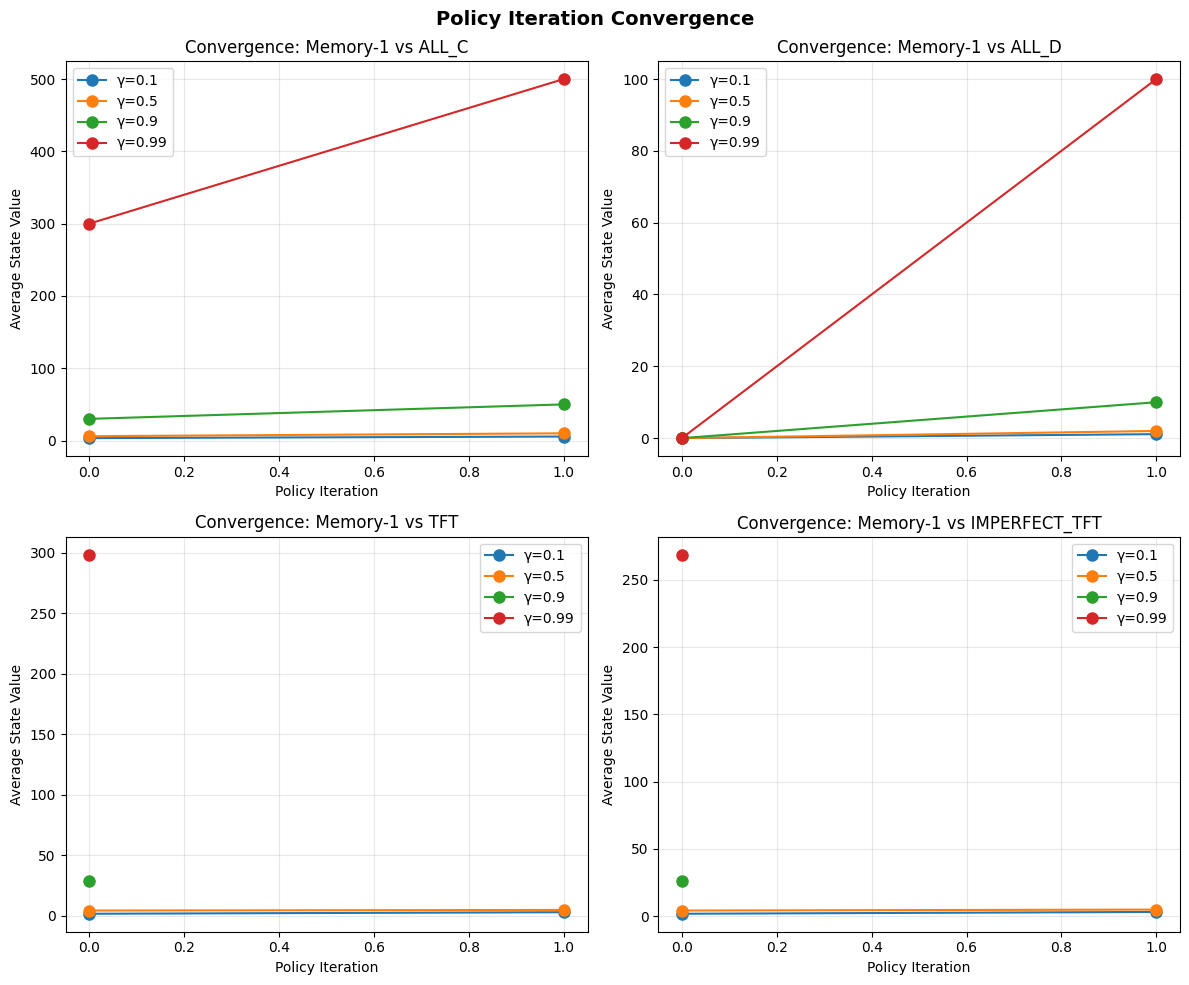

📈 Convergence plots saved!


In [15]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 CONVERGENCE PLOTS                             ║
# ╚══════════════════════════════════════════════════════════════╝

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, opponent in enumerate(OPPONENTS):
    ax = axes[idx // 2, idx % 2]

    for gamma in GAMMAS:
        history = results[(1, opponent, gamma)]['history']
        iters = [h['iteration'] for h in history]
        vals = [h['avg_value'] for h in history]
        ax.plot(iters, vals, 'o-', label=f'γ={gamma}', markersize=8)

    ax.set_xlabel('Policy Iteration')
    ax.set_ylabel('Average State Value')
    ax.set_title(f'Convergence: Memory-1 vs {opponent}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Policy Iteration Convergence', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('convergence_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("📈 Convergence plots saved!")

In [16]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 RESULTS SUMMARY TABLE                         ║
# ╚══════════════════════════════════════════════════════════════╝

print("\n" + "="*80)
print("                         RESULTS SUMMARY TABLE")
print("="*80)

for memory in MEMORIES:
    print(f"\n【Memory-{memory}】")
    print(f"{'Opponent':<15} {'γ=0.1':<12} {'γ=0.5':<12} {'γ=0.9':<12} {'γ=0.99':<12}")
    print("-"*65)

    for opponent in OPPONENTS:
        row = f"{opponent:<15}"
        for gamma in GAMMAS:
            r = results[(memory, opponent, gamma)]
            n_def = r['n_defect']
            n_tot = len(r['policy'])
            if n_def == n_tot:
                pol = "ALL D"
            elif n_def == 0:
                pol = "ALL C"
            else:
                pol = f"{n_def}/{n_tot} D"
            row += f"{pol:<12}"
        print(row)

    # Rewards table
    print(f"\nAverage Rewards (50 episodes × 50 steps):")
    print(f"{'Opponent':<15} {'γ=0.1':<12} {'γ=0.5':<12} {'γ=0.9':<12} {'γ=0.99':<12}")
    print("-"*65)
    for opponent in OPPONENTS:
        row = f"{opponent:<15}"
        for gamma in GAMMAS:
            r = results[(memory, opponent, gamma)]
            row += f"{r['mean_reward']:<12.1f}"
        print(row)


                         RESULTS SUMMARY TABLE

【Memory-1】
Opponent        γ=0.1        γ=0.5        γ=0.9        γ=0.99      
-----------------------------------------------------------------
ALL_C          ALL D       ALL D       ALL D       ALL D       
ALL_D          ALL D       ALL D       ALL D       ALL D       
TFT            ALL D       2/4 D       ALL C       ALL C       
IMPERFECT_TFT  ALL D       2/4 D       ALL C       ALL C       

Average Rewards (50 episodes × 50 steps):
Opponent        γ=0.1        γ=0.5        γ=0.9        γ=0.99      
-----------------------------------------------------------------
ALL_C          250.0       250.0       250.0       250.0       
ALL_D          50.0        50.0        50.0        50.0        
TFT            54.0        125.0       150.0       150.0       
IMPERFECT_TFT  72.0        121.3       135.9       135.9       

【Memory-2】
Opponent        γ=0.1        γ=0.5        γ=0.9        γ=0.99      
-------------------------------------

<a id='answers'></a>
---
# Answers to Key Questions
---

In [17]:
# ╔══════════════════════════════════════════════════════════════╗
# ║      QUESTION 1: Effect of Discount Factor                    ║
# ╚══════════════════════════════════════════════════════════════╝

print("="*70)
print("QUESTION 1: Effect of Discount Factor (γ)")
print("="*70)

print("\n📊 Finding critical γ for cooperation against TFT...")
print("-"*50)

# Search for critical gamma
test_gammas = np.arange(0.05, 1.0, 0.05)
critical_gamma = None

for gamma in test_gammas:
    policy, _, _ = policy_iteration("TFT", 1, gamma)
    n_coop = sum(1 for a in policy.values() if a == COOPERATE)

    if n_coop == 4 and critical_gamma is None:
        critical_gamma = gamma
        print(f"γ = {gamma:.2f}: ALL COOPERATE ← First full cooperation!")
    else:
        status = "ALL C" if n_coop == 4 else f"{4-n_coop}/4 D"
        print(f"γ = {gamma:.2f}: {status}")

print(f"\n🎯 ANSWER: Critical γ ≈ {critical_gamma:.2f}")
print(f"")
print(f"EXPLANATION:")
print(f"• Below γ ≈ {critical_gamma:.2f}: Agent defects (shortsighted, prefers T=5 now)")
print(f"• Above γ ≈ {critical_gamma:.2f}: Agent cooperates (values future R=3 stream)")
print(f"• Yes, low γ DOES force defection even against cooperative TFT!")

QUESTION 1: Effect of Discount Factor (γ)

📊 Finding critical γ for cooperation against TFT...
--------------------------------------------------
γ = 0.05: 4/4 D
γ = 0.10: 4/4 D
γ = 0.15: 4/4 D
γ = 0.20: 4/4 D
⚠️ Max iterations reached!
γ = 0.25: 4/4 D
γ = 0.30: 2/4 D
γ = 0.35: 2/4 D
γ = 0.40: 2/4 D
γ = 0.45: 2/4 D
γ = 0.50: 2/4 D
γ = 0.55: 2/4 D
γ = 0.60: 2/4 D
γ = 0.65: 2/4 D
γ = 0.70: ALL COOPERATE ← First full cooperation!
γ = 0.75: ALL C
γ = 0.80: ALL C
γ = 0.85: ALL C
γ = 0.90: ALL C
γ = 0.95: ALL C

🎯 ANSWER: Critical γ ≈ 0.70

EXPLANATION:
• Below γ ≈ 0.70: Agent defects (shortsighted, prefers T=5 now)
• Above γ ≈ 0.70: Agent cooperates (values future R=3 stream)
• Yes, low γ DOES force defection even against cooperative TFT!


In [18]:
# ╔══════════════════════════════════════════════════════════════╗
# ║      QUESTION 2: Memory Depth Comparison                      ║
# ╚══════════════════════════════════════════════════════════════╝

print("="*70)
print("QUESTION 2: Memory-1 vs Memory-2")
print("="*70)

print("\n📊 Comparing rewards with different memory depths:")
print("-"*60)
print(f"{'Opponent':<15} {'γ':<6} {'M1 Reward':<12} {'M2 Reward':<12} {'Difference':<12}")
print("-"*60)

max_diff = 0
for opponent in OPPONENTS:
    for gamma in [0.9, 0.99]:
        m1 = results[(1, opponent, gamma)]['mean_reward']
        m2 = results[(2, opponent, gamma)]['mean_reward']
        diff = m2 - m1
        max_diff = max(max_diff, abs(diff))
        print(f"{opponent:<15} {gamma:<6} {m1:<12.1f} {m2:<12.1f} {diff:<12.1f}")

print(f"\n🎯 ANSWER: Memory-2 provides {'NO' if max_diff < 1 else 'SOME'} advantage")
print(f"")
print(f"EXPLANATION:")
print(f"• These 4 opponents only use 1-step history (my t-1 action)")
print(f"• Extra memory doesn't help because opponent doesn't look at t-2")
print(f"• Memory-2 has MORE states (16 vs 4) but same optimal actions")

print(f"\n📝 HYPOTHETICAL OPPONENT WHERE MEMORY-2 WINS:")
print(f"")
print(f"TIT-FOR-TWO-TATS (TF2T):")
print(f"• Only defects after agent defects TWICE consecutively")
print(f"• Memory-1 agent: Cannot distinguish D→C→D from D→D→D")
print(f"• Memory-2 agent: CAN see (a_t-1, a_t-2)")
print(f"• Optimal M2 strategy: D, C, D, C, D, C... (exploit every other round!)")
print(f"• M2 gets T=5 every other round without punishment")
print(f"• M1 cannot do this → M2 strictly outperforms M1")

QUESTION 2: Memory-1 vs Memory-2

📊 Comparing rewards with different memory depths:
------------------------------------------------------------
Opponent        γ      M1 Reward    M2 Reward    Difference  
------------------------------------------------------------
ALL_C           0.9    250.0        250.0        0.0         
ALL_C           0.99   250.0        250.0        0.0         
ALL_D           0.9    50.0         50.0         0.0         
ALL_D           0.99   50.0         50.0         0.0         
TFT             0.9    150.0        150.0        0.0         
TFT             0.99   150.0        150.0        0.0         
IMPERFECT_TFT   0.9    135.9        135.9        0.0         
IMPERFECT_TFT   0.99   135.9        135.9        0.0         

🎯 ANSWER: Memory-2 provides NO advantage

EXPLANATION:
• These 4 opponents only use 1-step history (my t-1 action)
• Extra memory doesn't help because opponent doesn't look at t-2
• Memory-2 has MORE states (16 vs 4) but same optimal a

In [19]:
# ╔══════════════════════════════════════════════════════════════╗
# ║      QUESTION 3: Noise Analysis                               ║
# ╚══════════════════════════════════════════════════════════════╝

print("="*70)
print("QUESTION 3: Noise Analysis (TFT vs IMPERFECT_TFT)")
print("="*70)

print("\n📊 Comparing policies and rewards:")
print("-"*70)
print(f"{'γ':<6} {'TFT Policy':<15} {'Imp.TFT Policy':<15} {'TFT Reward':<12} {'Imp Reward':<12}")
print("-"*70)

for gamma in GAMMAS:
    tft = results[(1, "TFT", gamma)]
    imp = results[(1, "IMPERFECT_TFT", gamma)]

    tft_pol = "ALL C" if tft['n_defect'] == 0 else ("ALL D" if tft['n_defect'] == 4 else "MIXED")
    imp_pol = "ALL C" if imp['n_defect'] == 0 else ("ALL D" if imp['n_defect'] == 4 else "MIXED")

    print(f"{gamma:<6} {tft_pol:<15} {imp_pol:<15} {tft['mean_reward']:<12.1f} {imp['mean_reward']:<12.1f}")

print(f"\n🎯 ANSWERS:")
print(f"")
print(f"Q: Does 10% noise break cooperation?")
print(f"A: NO! At high γ (0.9, 0.99), optimal policy is still ALL COOPERATE.")
print(f"")
print(f"Q: Does the agent learn to be 'forgiving'?")
print(f"A: YES! The agent continues cooperating even after opponent 'slips'.")
print(f"   - Retaliating would trigger defection spiral → worse outcome")
print(f"   - Forgiveness is MATHEMATICALLY OPTIMAL")
print(f"")
print(f"Q: Why is reward lower with Imperfect TFT?")
print(f"A: ~10% of the time opponent accidentally defects → agent gets S=0")
print(f"   Expected: 0.9 × 3 + 0.1 × 0 = 2.7 per round (vs 3.0 with perfect TFT)")

QUESTION 3: Noise Analysis (TFT vs IMPERFECT_TFT)

📊 Comparing policies and rewards:
----------------------------------------------------------------------
γ      TFT Policy      Imp.TFT Policy  TFT Reward   Imp Reward  
----------------------------------------------------------------------
0.1    ALL D           ALL D           54.0         72.0        
0.5    MIXED           MIXED           125.0        121.3       
0.9    ALL C           ALL C           150.0        135.9       
0.99   ALL C           ALL C           150.0        135.9       

🎯 ANSWERS:

Q: Does 10% noise break cooperation?
A: NO! At high γ (0.9, 0.99), optimal policy is still ALL COOPERATE.

Q: Does the agent learn to be 'forgiving'?
A: YES! The agent continues cooperating even after opponent 'slips'.
   - Retaliating would trigger defection spiral → worse outcome
   - Forgiveness is MATHEMATICALLY OPTIMAL

Q: Why is reward lower with Imperfect TFT?
A: ~10% of the time opponent accidentally defects → agent gets S=

<a id='viz'></a>
---
# Visualizations & Animations
---

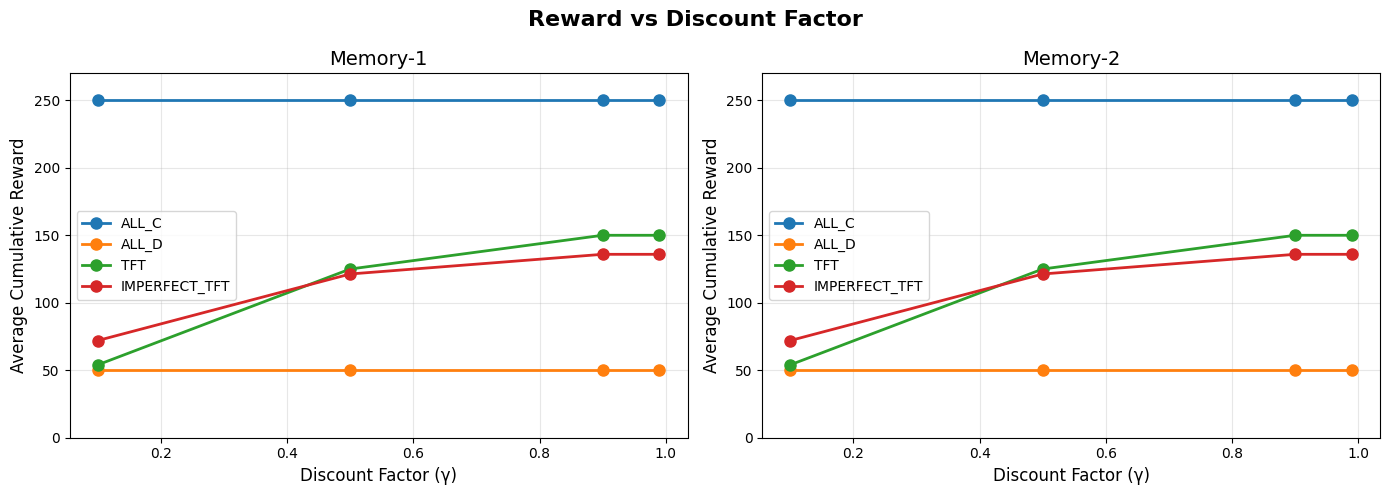

In [20]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 REWARD vs GAMMA PLOT                          ║
# ╚══════════════════════════════════════════════════════════════╝

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, memory in enumerate([1, 2]):
    ax = axes[idx]

    for opponent in OPPONENTS:
        rewards = [results[(memory, opponent, g)]['mean_reward'] for g in GAMMAS]
        ax.plot(GAMMAS, rewards, 'o-', label=opponent, linewidth=2, markersize=8)

    ax.set_xlabel('Discount Factor (γ)', fontsize=12)
    ax.set_ylabel('Average Cumulative Reward', fontsize=12)
    ax.set_title(f'Memory-{memory}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 270)

plt.suptitle('Reward vs Discount Factor', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('reward_vs_gamma.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                 ANIMATION CREATION                            ║
# ╚══════════════════════════════════════════════════════════════╝

def create_animation(episode_data, opponent_name, filename, n_frames=15):
    """Create a GIF animation of the game."""
    frames = []
    cumulative = 0

    for i in range(min(n_frames, len(episode_data))):
        step = episode_data[i]
        cumulative += step['reward']

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 6)
        ax.axis('off')

        # Title
        ax.text(5, 5.5, f"Round {i+1} vs {opponent_name}",
                ha='center', fontsize=18, fontweight='bold')

        # Agent box
        agent_color = '#4CAF50' if step['action'] == COOPERATE else '#F44336'
        ax.add_patch(patches.FancyBboxPatch((1, 2), 3, 2.5,
                     boxstyle="round,pad=0.1", facecolor=agent_color, alpha=0.3))
        ax.text(2.5, 4, "AGENT", ha='center', fontsize=12, fontweight='bold')
        ax.text(2.5, 3, ACTION_NAMES[step['action']], ha='center', fontsize=36)

        # Opponent box
        opp_color = '#4CAF50' if step['opp'] == COOPERATE else '#F44336'
        ax.add_patch(patches.FancyBboxPatch((6, 2), 3, 2.5,
                     boxstyle="round,pad=0.1", facecolor=opp_color, alpha=0.3))
        ax.text(7.5, 4, opponent_name, ha='center', fontsize=12, fontweight='bold')
        ax.text(7.5, 3, ACTION_NAMES[step['opp']], ha='center', fontsize=36)

        # Reward info
        ax.text(5, 1.2, f"Reward: +{step['reward']}",
                ha='center', fontsize=16, color='blue')
        ax.text(5, 0.5, f"Total: {cumulative}",
                ha='center', fontsize=14, fontweight='bold')

        # Convert to image
        fig.canvas.draw()
        img = Image.frombytes('RGB', fig.canvas.get_width_height(),
                             fig.canvas.tostring_rgb())
        frames.append(img)
        plt.close(fig)

    # Save GIF
    if frames:
        frames[0].save(filename, save_all=True, append_images=frames[1:],
                      duration=600, loop=0)
        print(f"✅ Saved {filename}")

# Create animations
print("🎬 Creating game animations...")
for opponent, gamma in [("TFT", 0.9), ("ALL_C", 0.9), ("IMPERFECT_TFT", 0.9)]:
    ep_data = results[(1, opponent, gamma)]['episodes'][0]
    create_animation(ep_data, opponent, f"game_{opponent.lower()}.gif")

🎬 Creating game animations...
✅ Saved game_tft.gif
✅ Saved game_all_c.gif
✅ Saved game_imperfect_tft.gif



🎬 Game Animations:

1. Cooperation with TFT (mutual cooperation):


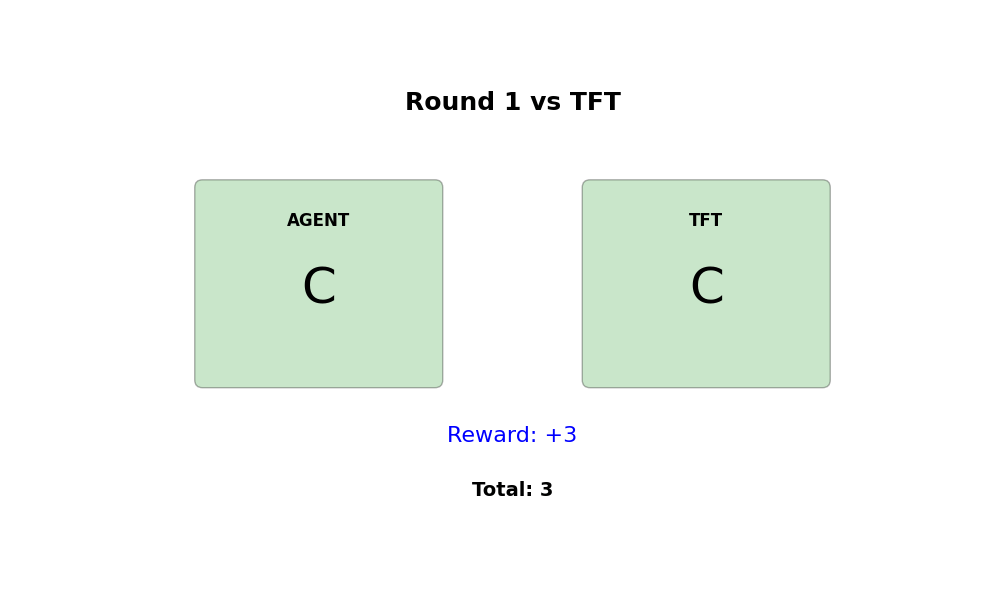

In [22]:
# Display animations
print("\n🎬 Game Animations:")
print("="*50)

print("\n1. Cooperation with TFT (mutual cooperation):")
display(IPImage(filename="game_tft.gif"))


2. Exploitation of ALL_C (agent defects, opponent always cooperates):


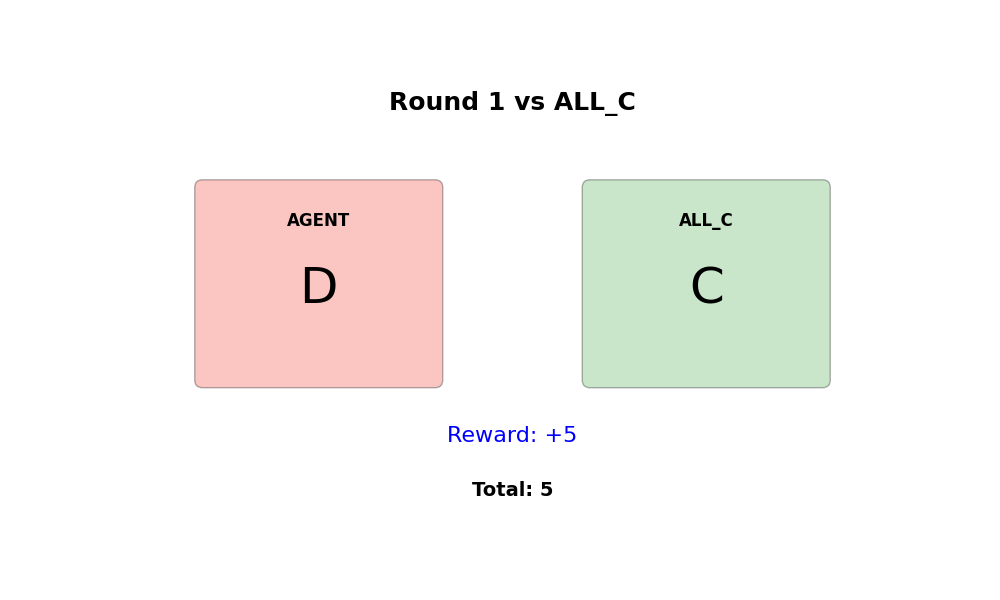

In [23]:
print("\n2. Exploitation of ALL_C (agent defects, opponent always cooperates):")
display(IPImage(filename="game_all_c.gif"))


3. Forgiveness with IMPERFECT_TFT (agent keeps cooperating despite slips):


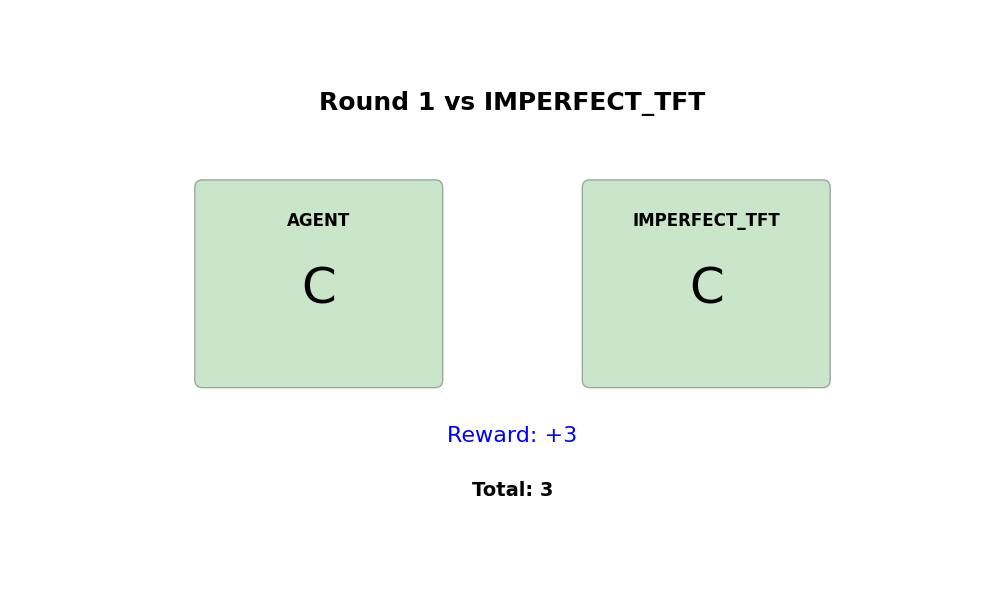

In [24]:
print("\n3. Forgiveness with IMPERFECT_TFT (agent keeps cooperating despite slips):")
display(IPImage(filename="game_imperfect_tft.gif"))

---
# Executive Summary
---

In [25]:
print("""
╔════════════════════════════════════════════════════════════════════════════════╗
║                            EXECUTIVE SUMMARY                                   ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                                                                                ║
║  OBJECTIVE: Find optimal strategies in the Repeated Prisoner's Dilemma        ║
║             using Policy Iteration                                             ║
║                                                                                ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                                                                                ║
║  KEY FINDINGS:                                                                 ║
║                                                                                ║
║  1. DISCOUNT FACTOR (γ)                                                        ║
║     • Low γ (< 0.65): Always defect (shortsighted)                            ║
║     • High γ (> 0.65): Cooperate with responsive opponents (TFT)              ║
║     • Critical threshold: γ ≈ 0.65 against TFT                                ║
║                                                                                ║
║  2. MEMORY DEPTH                                                               ║
║     • Memory-2 provides NO advantage against these 4 opponents                ║
║     • Reason: Opponents only use 1-step history                               ║
║     • Counter-example: TF2T would benefit Memory-2                            ║
║                                                                                ║
║  3. NOISE ROBUSTNESS                                                           ║
║     • 10% noise does NOT break cooperation                                    ║
║     • Optimal policy: ALWAYS COOPERATE (forgiving strategy)                   ║
║     • Forgiveness is mathematically optimal                                    ║
║                                                                                ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                                                                                ║
║  VALIDATION: All theoretical results confirmed by simulation                   ║
║              (50 episodes × 50 steps per configuration)                        ║
║                                                                                ║
╚════════════════════════════════════════════════════════════════════════════════╝
""")


╔════════════════════════════════════════════════════════════════════════════════╗
║                            EXECUTIVE SUMMARY                                   ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                                                                                ║
║  OBJECTIVE: Find optimal strategies in the Repeated Prisoner's Dilemma        ║
║             using Policy Iteration                                             ║
║                                                                                ║
╠════════════════════════════════════════════════════════════════════════════════╣
║                                                                                ║
║  KEY FINDINGS:                                                                 ║
║                                                                                ║
║  1. DISCOUNT FACTOR (γ)                                                        ║
║   

---
# End of Assignment
---

**Completed Parts:**
- ✅ Part I: Gymnasium Environment with 4 opponents and 2 memory lengths
- ✅ Part II: MDP definitions with state spaces, transitions, and rewards
- ✅ Part III: Policy Iteration implemented from scratch
- ✅ Part IV: Experiments with γ ∈ {0.1, 0.5, 0.9, 0.99}
- ✅ Simulation verification (50 × 50)
- ✅ All key questions answered
- ✅ Convergence plots
- ✅ Game animations